<a href="https://colab.research.google.com/github/cindykhris/SummerInternship2020/blob/master/PCA_SARS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Principal Component Analysis (PCA) and Visualization using Python

**Introduction**

Description: In this study, I analyzed the gene expression of coronaviruses (CoVs) infections to determine how each virus differs when causing a disease. Here, I focused the analysis on samples derived from SARS-CoV, MERS, and SARS-CoV-2. 
The raw sequence data (fastq files) for the SARS-CoV-1 was downloaded from GEO [GSE56192](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE56192), including their corresponding Mock-treated controls). The raw sequence data (fastq files) for the SARS-CoV-2 infections were downloaded from GEO [GSE147507](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE147507)), including their corresponding Mock-treated controls). The raw sequence data (fastq files) for the MERS infections were downloaded from GEO [GSE139516](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE139516), including their corresponding Mock-treated controls. Gene expression matrixes were generated using the [BioInfoPlatform](https://server.t-bio.info) described below:


*   PreProcessing
    
      * PCR clean - to remove duplicates from the PCR run  thus reducing redundancy. 
      * Trimmomatic - removes adapter sequences
*   Mapping 
      * Bowtie-2t
* Quantification 

    * RSEM -  Fragment Per Kilobase of transcript per Million mapped reads  for Paired-End Reads

*   Differential Expression

    * DESeq2

Principal Component Analysis steps described in [Renesh Bedre github](https://reneshbedre.github.io/blog/pca_3d.html) were used to analyse the generated gene expression matrix. 

In [108]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import bioinfokit
from bioinfokit.analys import get_data
from bioinfokit.visuz import cluster
import pandas as pd
import numpy as np

In [89]:
#Load SARS gene expression
df = pd.read_table('drive/My Drive/SummerResearch/DESeq_SARS_expression_genes.txt')
df = df.drop('id',axis=1)
df.head(5)

,group_1_sample_1_SRR1192353_PE,group_1_sample_2_SRR1192354_PE,group_1_sample_3_SRR1192370_PE,group_1_sample_4_SRR1192371_PE,group_1_sample_5_SRR1192398_PE,group_1_sample_6_SRR1192399_PE,group_2_sample_1_SRR1193100_PE,group_2_sample_2_SRR1193101_PE,group_2_sample_3_SRR1193013_PE,group_2_sample_4_SRR1193014_PE,group_2_sample_5_SRR1193016_PE,group_2_sample_6_SRR1193017_PE
0,1005.00,1016.58,1011.00,952.00,979.00,921.00,605.01,623.00,627.00,642.00,578.00,564.00
1,1407.00,1360.00,1702.00,1645.00,1193.00,1233.00,1269.00,1268.00,1103.00,1066.00,1118.00,1103.00
2,386.15,371.19,369.27,340.79,328.45,364.65,247.37,270.26,223.31,248.28,234.34,245.02
3,374.02,339.90,232.66,238.59,314.80,335.48,243.82,280.23,236.33,242.07,234.65,247.01
4,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [90]:
df = df.rename(columns={
    'group_1_sample_1_SRR1192353_PE': 'A', 
    'group_1_sample_2_SRR1192354_PE': 'A' ,
    'group_1_sample_3_SRR1192370_PE': 'A' , 
    'group_1_sample_4_SRR1192371_PE': 'A' ,
    'group_1_sample_5_SRR1192398_PE': 'A', 
    'group_1_sample_6_SRR1192399_PE': 'A',
    'group_2_sample_1_SRR1193100_PE': 'B', 
    'group_2_sample_2_SRR1193101_PE': 'B',
    'group_2_sample_3_SRR1193013_PE': 'B', 
    'group_2_sample_4_SRR1193014_PE': 'B',
    'group_2_sample_5_SRR1193016_PE': 'B', 
    'group_2_sample_6_SRR1193017_PE': 'B'})

In [91]:
df.head(5)

,A,A,A,A,A,A,B,B,B,B,B,B
0,1005.00,1016.58,1011.00,952.00,979.00,921.00,605.01,623.00,627.00,642.00,578.00,564.00
1,1407.00,1360.00,1702.00,1645.00,1193.00,1233.00,1269.00,1268.00,1103.00,1066.00,1118.00,1103.00
2,386.15,371.19,369.27,340.79,328.45,364.65,247.37,270.26,223.31,248.28,234.34,245.02
3,374.02,339.90,232.66,238.59,314.80,335.48,243.82,280.23,236.33,242.07,234.65,247.01
4,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [92]:
#Standarization
df_st = StandardScaler().fit_transform(df)

In [93]:
#see few rows of standarized dataset
pd.DataFrame(df_st, columns=df.columns).head()

,A,A,A,A,A,A,B,B,B,B,B,B
0,-0.016866,-0.014429,-0.015158,-0.022798,-0.001075,-0.009458,-0.026505,-0.021238,-0.022390,-0.018114,-0.023841,-0.026523
1,0.039491,0.034190,0.086736,0.080561,0.033565,0.041521,0.132168,0.134077,0.082773,0.076124,0.112146,0.110139
2,-0.103625,-0.105797,-0.109787,-0.113959,-0.106378,-0.100363,-0.111969,-0.106178,-0.111578,-0.105623,-0.110384,-0.107400
3,-0.105326,-0.110227,-0.129931,-0.129202,-0.108587,-0.105129,-0.112818,-0.103777,-0.108701,-0.107003,-0.110306,-0.106896
4,-0.157761,-0.158347,-0.164239,-0.164787,-0.159381,-0.159945,-0.171083,-0.171016,-0.160914,-0.160805,-0.169397,-0.169524


In [94]:
#perfom PCA
pca_out = PCA().fit(df_st)

In [95]:
#get the component variance
#proportion of Variance (from PC1 to PC6)
pca_out.explained_variance_ratio_

array([9.90289805e-01, 6.92743176e-03, 1.93214560e-03, 4.35855685e-04,
       2.37222944e-04, 1.62208640e-04, 3.31876682e-06, 3.17755687e-06,
       2.82246673e-06, 2.37668842e-06, 1.88237745e-06, 1.75232675e-06])

In [96]:
#cumulative propotion of variance (from PC1 to PC6)
np.cumsum(pca_out.explained_variance_ratio_
          )

array([0.99028981, 0.99721724, 0.99914938, 0.99958524, 0.99982246,
       0.99998467, 0.99998799, 0.99999117, 0.99999399, 0.99999637,
       0.99999825, 1.        ])

In [97]:
#get component loadings (correlation coefficint between original variables and the component )
loadings = pca_out.components_
num_pc   = pca_out.n_features_
pc_list  = ['PC'+str(i) for i in list(range(1,num_pc+1))]


In [98]:
loading_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loading_df['variable'] = df.columns.values
loading_df = loading_df.set_index('variable')
loading_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
variable,,,,,,,,,,,,
A,0.289518,-0.048637,-0.358388,-0.026901,0.411361,0.355106,0.117416,-0.033663,0.017286,0.390564,-0.130019,0.551965
A,0.289538,-0.044619,-0.354263,-0.020278,0.413980,0.325053,-0.148345,0.005060,-0.019716,-0.385334,0.138369,-0.566723
A,0.286278,-0.526001,0.359888,-0.117028,0.027268,0.011134,0.106137,-0.051973,-0.019679,0.281349,0.631396,-0.071506
A,0.286381,-0.517595,0.360670,-0.119316,0.061494,-0.011102,-0.109069,0.049895,0.019639,-0.281869,-0.634678,0.069430
A,0.289163,-0.176906,-0.348621,0.326956,-0.258957,-0.303958,0.120549,-0.029184,-0.078891,0.471542,-0.284855,-0.414851
A,0.289178,-0.175323,-0.346544,0.324905,-0.233240,-0.320630,-0.104752,0.051369,0.079312,-0.472116,0.279296,0.426585
B,0.289078,0.234945,0.242800,0.303661,-0.264799,0.385039,0.454486,-0.487808,0.098142,-0.187994,-0.044315,-0.015766
B,0.289058,0.239633,0.244448,0.291507,-0.257864,0.372620,-0.485549,0.482485,-0.105969,0.165894,0.034395,0.021626
B,0.289419,0.174549,-0.116741,-0.533902,-0.290862,-0.029052,-0.067473,0.051866,0.696690,0.072965,-0.007183,-0.060409


In [99]:
#get correalation matrix plot for loadings
import seaborn as sns
import matplotlib.pyplot as plt



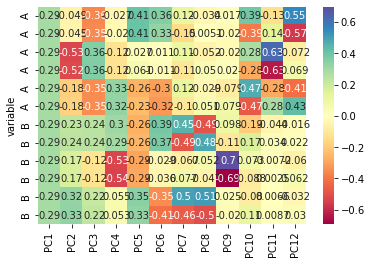

In [100]:
ax = sns.heatmap(loading_df, annot=True, cmap='Spectral')
plt.show()

In [101]:
#Principal component (PC) retention
#get eigenvalues (from PC1 to PC6)
pca_out.explained_variance_

array([1.18838350e+01, 8.31316812e-02, 2.31864445e-02, 5.23042552e-03,
       2.84676094e-03, 1.94656222e-03, 3.98263995e-05, 3.81318292e-05,
       3.38706193e-05, 2.85211188e-05, 2.25892087e-05, 2.10285534e-05])

In [102]:
#get screen plot (for scree or elbow test)


In [103]:
cluster.screeplot(obj=[pc_list, pca_out.explained_variance_ratio_])
#scree plot will be saved in the same directory with name screenplot.png

In [104]:
#PCA loadings plot
#get PCA loadings plots (2D and 3D)
#2D
cluster.pcaplot(x=loadings[0], y=loadings[1], labels=df.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2))


In [105]:
# 3D
cluster.pcaplot(x=loadings[0], y=loadings[1], z=loadings[2],  labels=df.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca_out.explained_variance_ratio_[2]*100, 2))

In [107]:
#PCA biplot
pca_scores = PCA().fit_transform(df_st)

#get 2D biplot
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

#get 3D biplot
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca_out.explained_variance_ratio_[2]*100, 2))
